# Image reconstruction using SOM

This example of image reconstruction/clustering follows closely [this nice example].
All credits to them.

[this nice example]: https://www.youtube.com/watch?v=ipH_Df2MbPI

In [34]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)

from functools import partial

import jax
from jax import random
from jax import jit
from jax import lax
import jax.numpy as jnp

from PIL import Image

from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

from IPython.display import HTML

%load_ext autoreload
%autoreload 2

import somx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We reproduce the cover of "Six Rhythms" by Two Fingers (Amon Tobin), B&W

In [48]:
img_size = 256

img = Image.open('data/six_rhythms.jpg').convert('L')
img = img.resize((img_size, img_size))
img_matrix = jnp.asarray(img)
img_matrix.shape[0] == img_matrix.shape[1]
img_size = img_matrix.shape[0]

img_prob = (255.0 - img_matrix) / 255.0
img_prob = img_prob.at[img_prob<1e-1].set(0) # To speed up the learning
img_prob = img_prob / jnp.sum(img_prob, dtype=jnp.float32)

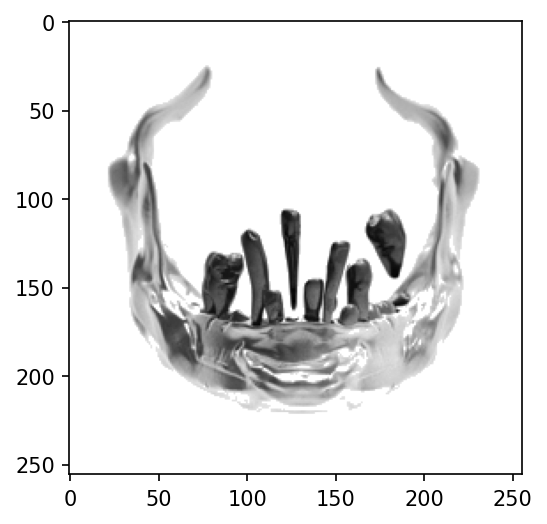

In [49]:
plt.figure(dpi=150)
plt.imshow(img_prob, cmap='binary')

We assign a unique identifier to each pixel position

In [54]:
# Create a unique identifies per pixel
locations_array = jnp.arange(len(img_prob.reshape(-1)), dtype=jnp.int32).reshape(-1, 1)

print('identifier =', locations_array)
print('shape =', locations_array.shape)

identifier = [[    0]
 [    1]
 [    2]
 ...
 [65533]
 [65534]
 [65535]]
shape = (65536, 1)


The normalized intensity of each pixel is interpreted as a probability, and used to sample pixel positions:

In [55]:
# Probability of each pixel, in a flattened array
pixel_prob = img_prob.reshape(-1, 1)

print('probabilities =', pixel_prob)
print('shape =', pixel_prob.shape)

probabilities = [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
shape = (65536, 1)


Our input is the set of coordinates of each pixel in the 2D image:

In [56]:
# We use the positions in the 2D image as input
X = []
for row in range(img_size):
    for col in range(img_size):
        X.append(jnp.array([row, col]))
X = jnp.array(X)

We use a SOM size of 128 $\times$ 128, and train in batches of $64$ samples for a total of $10000$ rounds.

We use an exponential decay for both the learning rate and the neighbor radius.

We collect the prototypes every $50$ batches.

In [57]:
# Options =======================================================
som_size = 128
batch_size = 64
n_rounds = 10000

learning_rate = 1.0
learning_rate_decay_rate = 0.1

neighbor_radius = 5
neighbor_radius_decay_rate = 100*(1-(1 / neighbor_radius)**(1/n_rounds))

history_every = 50
key = random.PRNGKey(0)
# ==============================================================

We write the training loop manually:

In [21]:
# Prototypes shape: we have a `som_size` x `som_size` grid of prototypes
prototypes_shape = jnp.array([som_size, som_size])

# Total number of prototypes
n_prototypes = somx.som_n_prototypes(prototypes_shape)

# Topology of the prototypes
topology = somx.som_get_topology(prototypes_shape)

# Initialize the prototypes
key, key_init = random.split(key)
prototypes = random.randint(key_init, minval=jnp.min(X), maxval=jnp.max(X), shape=(n_prototypes, X.shape[1]))
prototypes = jnp.float32(prototypes)

# We train in batches, sampling the positions according to their probability (pixel intensity)
iterator = tqdm(range(n_rounds), ncols=60, desc='Batch')
history = [prototypes]

for i in iterator:
    
    key, key_batch = random.split(key)
    loc_batch = random.choice(key_batch, locations_array.reshape(-1), p=pixel_prob.reshape(-1), shape=(batch_size,))
    X_batch = X[loc_batch]
    
    # Update the learning rate
    learning_rate = somx.exponential_decay(learning_rate, decay_rate=learning_rate_decay_rate)
    
    # Update the neighbor radius
    neighbor_radius = somx.exponential_decay(neighbor_radius, decay_rate=neighbor_radius_decay_rate)
    
    # Self-Organizing Map online update using a small batch of data
    prototypes = somx.som_step(X_batch, prototypes, topology, learning_rate, neighbor_radius)
    
    if i % history_every == 0:
        history.append(prototypes)
    

Batch: 100%|█████████| 10000/10000 [01:26<00:00, 116.24it/s]


In [58]:
@partial(jit, static_argnums=1)
def reconstruct_image(prototypes, img_size):
    '''
    Reconstruct the image given the prototypes (position of each pixel) and 
    the original image size.
    '''
    som_img = jnp.zeros((img_size, img_size), dtype=jnp.int32)
    locations = jnp.int32(jnp.round(prototypes))
    def inner_func(i, som_img):
        return som_img.at[locations[i][0], locations[i][1]].set(1)
    lower = 0
    upper = len(locations)
    som_img = lax.fori_loop(lower, upper, inner_func, som_img)
    return som_img

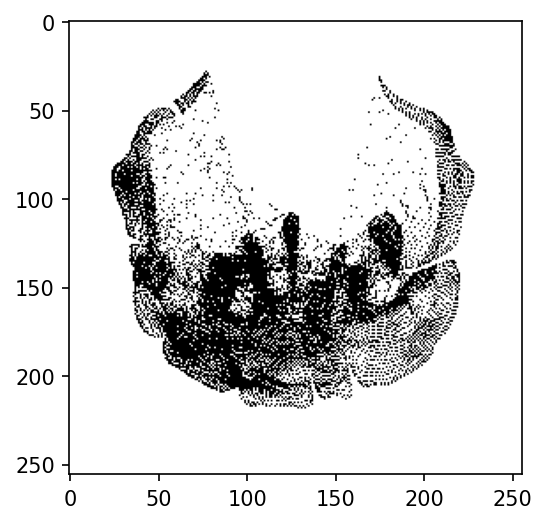

In [59]:
som_img = reconstruct_image(prototypes, img_size)
plt.figure(dpi=150)
plt.imshow(som_img, cmap='binary')

Here we visualize the training:

In [43]:
def animate_imshow(arrays, reconstruction_func, img_size, stride=None):
    
    fig, ax = plt.subplots(1, 1, dpi=150)
    im = ax.imshow(reconstruction_func(arrays[0], img_size=img_size), cmap='binary')
   
    if stride is not None:
        arrays = arrays[::stride]

    def animate(i):
        im = ax.imshow(reconstruction_func(arrays[i], img_size=img_size), cmap='binary')
        return im,
    
    anim = FuncAnimation(fig, animate, frames=len(arrays))
    return anim

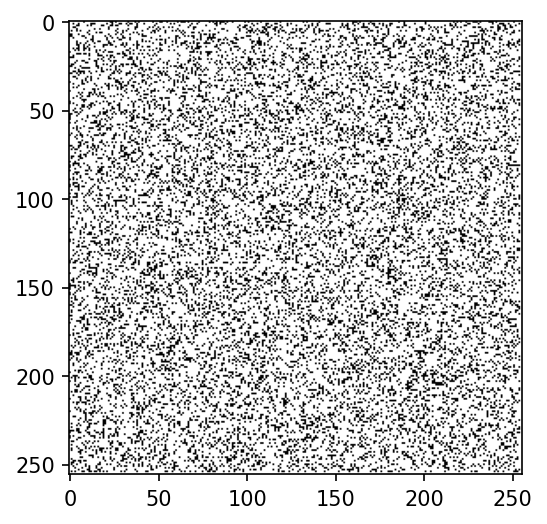

In [44]:
anim = animate_imshow(history, reconstruct_image, img_size, stride=1)

In [45]:
anim.save('movie/amon_tobin_reconstruction.mp4')

In [46]:
HTML(anim.to_html5_video())